In [1]:
import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


import os
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt

#Training the model
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from dataset import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")
from utils import classification_report

# rich: for a better display on terminal
from rich.table import Column, Table
from rich import box
from rich.console import Console

import librosa
import librosa.display

In [2]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, stim):
        _, _, filenames = next(os.walk(path))
        filenames = sorted(filenames)
        all_data = []
        all_label = []
        for dat in filenames:
            temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
            all_data.append(temp['data'])
            
            if stim == "Valence":
                all_label.append(temp['labels'][:,:1])
            elif stim == "Arousal":
                all_label.append(temp['labels'][:,1:2]) # Arousal
            else:
                all_label.append(temp['labels'][:,:2]) # All
                
        self.data = np.vstack(all_data)
        self.label = np.vstack(all_label)
        del temp, all_data, all_label

    def __len__(self):
        return self.data.shape[0]

   
    def __getitem__(self, idx):
        single_data = self.data[idx]
        single_label = self.label[idx].astype(float)
        
        batch = {
            'data': torch.Tensor(single_data),
            'label': torch.Tensor(single_label)
        }

        return batch

In [3]:
from model import Encoder
from train import trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

path = "../../../data_preprocessed_python"

model_params = {
    "MODEL": "Soft-attention", # Self-attention, Soft-attention, Hard-attention, #Hierarchical-attention
    "LSTM_MERGE_MODE" : 'sum', # concat / sum
    "STIM": "Arousal", #Arousal/ Valence/ All
    "BATCH_SIZE": 12,  # batch size
    "EPOCHS": 2,  # number of training epochs
    "LEARNING_RATE": 0.001,  # learning rate
}

Configured device:  cuda


In [4]:
dataset = Dataset(path, model_params["STIM"])

torch.manual_seed(1)
    
indices = torch.randperm(len(dataset)).tolist()
train_ind = int(0.8 * len(dataset))
train_set = torch.utils.data.Subset(dataset, indices[:train_ind])
val_set = torch.utils.data.Subset(dataset, indices[train_ind:])

train_params = {
    "batch_size": model_params["BATCH_SIZE"],
    "shuffle": True,
    "pin_memory": True,
}

val_params = {
    "batch_size": model_params["BATCH_SIZE"],
    "shuffle": True,
    "pin_memory": True,
}

In [5]:
train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

In [6]:
for item in train_loader:
    print(item['data'].shape)
    break
    
sample_rate = 128
# sequence length = 8064

torch.Size([12, 40, 8064])


In [7]:
one_sample = item['data'].numpy()
one_channel = one_sample[0, 0, :]

In [8]:
## Python
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
## Package
import glob 
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

In [9]:
# Spectogram
# Spectogram is a visual representation of the bands of spectrum of frequencies of sound or other signals as they vary with time.

def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

(125, 65)


Text(0.5, 0, 'Seconds')

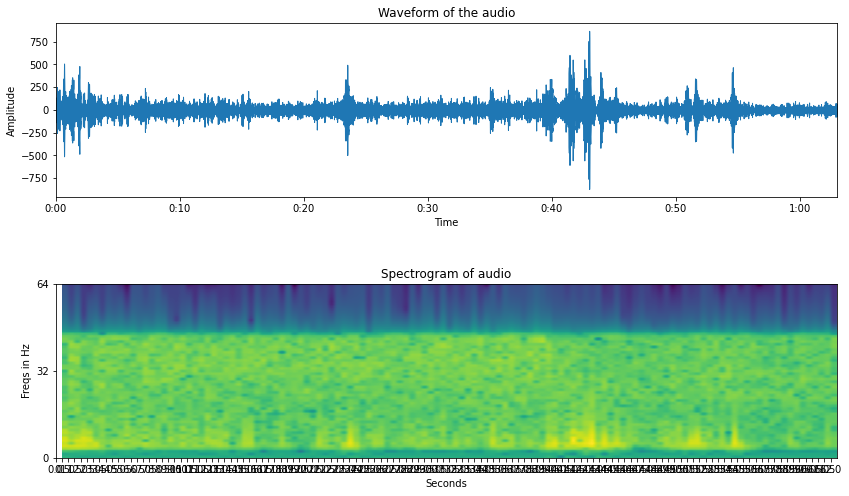

In [10]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(one_channel, sample_rate, window_size=1000, step_size=500)

print(spectrogram.shape)


fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(one_channel, sr=sample_rate)
fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

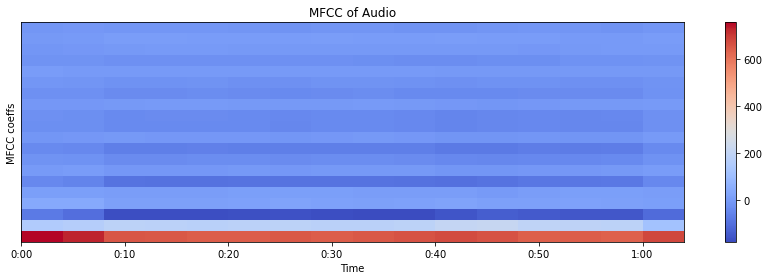

In [11]:
mfccs = librosa.feature.mfcc(one_channel, sr=sample_rate)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC of Audio')
plt.colorbar()
plt.tight_layout()

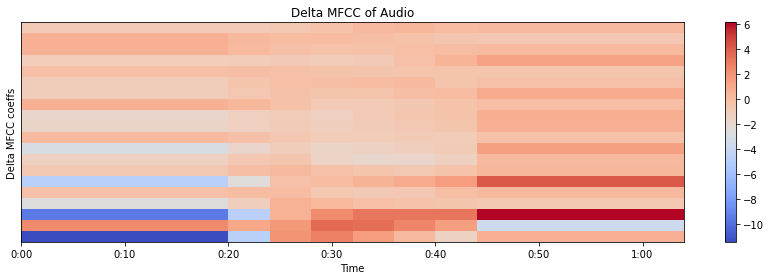

In [12]:
plt.figure(figsize=(12, 4))
delta_MFCCS =  librosa.feature.delta(mfccs,order=1)
librosa.display.specshow(delta_MFCCS, sr=sample_rate, x_axis='time')
plt.ylabel('Delta MFCC coeffs')
plt.xlabel('Time')
plt.title('Delta MFCC of Audio')
plt.colorbar()
plt.tight_layout()

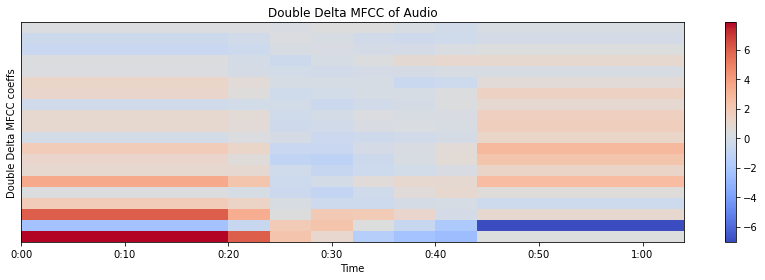

In [13]:
plt.figure(figsize=(12, 4))
d_delta_MFCCS =  librosa.feature.delta(mfccs,order=2)
librosa.display.specshow(d_delta_MFCCS, sr=sample_rate, x_axis='time')
plt.ylabel('Double Delta MFCC coeffs')
plt.xlabel('Time')
plt.title('Double Delta MFCC of Audio')
plt.colorbar()
plt.tight_layout()

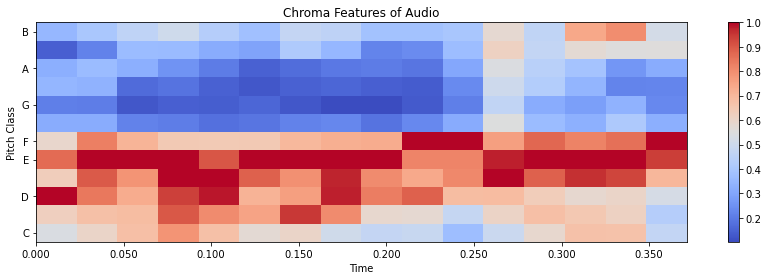

In [14]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(one_channel, sr=sample_rate, hop_length=hop_length)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length,cmap='coolwarm')
plt.ylabel('Pitch Class')
plt.xlabel('Time')
plt.title('Chroma Features of Audio')
plt.colorbar()
plt.tight_layout()
#librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')